In [1]:
AGENT_NAME = 'default_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_50.zip'
ADVERSARY_PATH = 'Models\Adversary\default_adversary_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_default_rwd_480'
DATASET_NAME = 'citylearn_challenge_2022_phase_2' #only action is electrical storage
ATTACK = 'Optimal myBB uninit'
INIT_DATA = 'baseline_obs'

In [2]:
from stable_baselines3 import PPO

from citylearn.data import DataSet

from KBMproject.mybb import BrendelBethgeAttack as BBA

import pandas as pd
import numpy as np
import os

import KBMproject.utilities as utils

%matplotlib inline

Define RL agent

In [3]:
agent = PPO.load(path=f"{AGENT_NAME}")
print('Model loaded from storage')

Model loaded from storage


In [4]:
adv_path = os.path.join(os.getcwd(), '..',ADVERSARY_PATH) #get adversary from parent directory
adv_path = os.path.normpath(adv_path) #resolve '..'
adversary = PPO.load(path=adv_path)
print('Model loaded from storage')

Model loaded from storage


In [5]:
env = utils.make_discrete_env(schema=DataSet.get_schema(DATASET_NAME),  
                        action_bins=agent.action_space[0].n,
                        seed=42)

In [6]:
bline_kpi, bline_obs, bline_a = utils.eval_agent(env, agent)

In [7]:
display(bline_kpi)

cost_function
annual_peak_average                      1.000000
carbon_emissions_total                   0.989494
cost_total                               0.971137
daily_one_minus_load_factor_average      0.993389
daily_peak_average                       1.002102
electricity_consumption_total            0.992623
monthly_one_minus_load_factor_average    0.997786
ramping_average                          1.116376
zero_net_energy                          1.020019
Name: District, dtype: float64

In [8]:
np.savetxt(f"baseline obs.csv", bline_obs, delimiter=",")
np.savetxt(f"baseline actions.csv", bline_a, delimiter=",")

In [9]:
observation_masks = pd.Series(1, index=env.observation_names[0]).to_frame(name='all')
observation_masks['mask_time'] = observation_masks['all']
observation_masks['mask_time'][observation_masks.index.str.contains('month|day|hour')] = 0

In [10]:
%%time
import logging
logging.basicConfig(level=logging.WARN)
kwargs = dict(norm=np.inf,
        targeted=True, #default false
        overshoot= 1.1,
        steps=1000,
        lr=1e-3,
        lr_decay=0.5,
        lr_num_decay=20,
        momentum=0.8,
        binary_search_steps=10,
        init_size=1_500_000, #default 100, finds sample matching the target class through iterative random search
        batch_size=1000, 
        )
kpi, obs, adv_obs, actions, targets, asr = utils.eval_targeted_attack(agent, adversary, 
                                                                        env=env, 
                                                                        ART_atk=utils.define_attack(agent, BBA, **kwargs),
                                                                        mask=observation_masks['mask_time'].to_numpy(),
                                                                        time_steps=None,
                                                                        )

100%|██████████| 8759/8759 [8:22:26<00:00,  3.44s/it, ASR=0.997]  


CPU times: total: 12h 3min 38s
Wall time: 8h 22min 28s


In [11]:
display(kpi)

cost_function
annual_peak_average                       1.727378
carbon_emissions_total                    3.224325
cost_total                                3.014372
daily_one_minus_load_factor_average       0.960486
daily_peak_average                        2.935352
electricity_consumption_total             3.266286
monthly_one_minus_load_factor_average     1.002746
ramping_average                          17.408588
zero_net_energy                           1.729170
Name: District, dtype: float64

In [12]:
np.savetxt(f"{ATTACK} targets.csv", targets, delimiter=",")
np.savetxt(f"{ATTACK} actions.csv", actions, delimiter=",")
np.savetxt(f"{ATTACK} adv obs.csv", adv_obs, delimiter=",")
np.savetxt(f"{ATTACK} obs.csv", obs, delimiter=",")

In [13]:
df_kpis= pd.concat([bline_kpi, kpi], axis='columns')

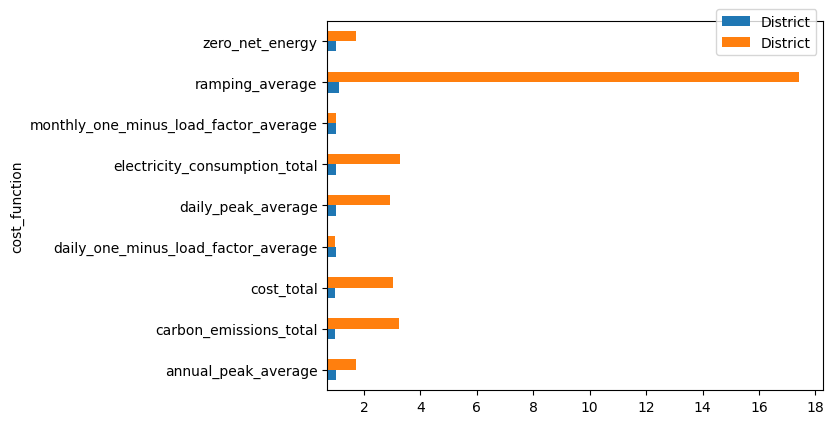

In [14]:
df_kpis.plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

In [15]:
df_kpis.to_csv('KPIs.csv')